In [1]:
#iteratively downsample the input to the kernelt fitting parameters, generate a null disribution of kernels 
Packages <- c("dplyr","cubature", "stringr","pracma","data.table", "gridExtra","viridis", "ggsignif", "broom", "ggpubr", "caret","cowplot","ggplot2","fields","bbmle", "dplyr", "tidyr", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/parentage/kernel_fitting/')


load("~/parentage/r_data/total_sampling_across_years.RData")
load("~/parentage/r_data/sampled_area_each_year.RData")
load("~/parentage/r_data/cumulative_prop_hab_sampled_by_site.RData")


#download.file(url = "https://github.com/pinskylab/genomics/blob/master/data/fish-obs.RData?raw=true", destfile = "~/parentage/r_data/fish-obs.RData")
fish_obs <- readRDS("~/parentage/r_data/fish-obs.RData") 
load("~/parentage/r_data/site_dist_info.RData")
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/Data_from_database/anem_db.RData?raw=true", destfile = "~/parentage/r_data/anem_db.RData")
load("~/parentage/r_data/anem_db.RData")
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/Data_from_database/dives_db.RData?raw=true", destfile = "~/parentage/r_data/dives_db.RData")
load("~/parentage/r_data/dives_db.RData")
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/Data_from_database/fish_db.RData?raw=true", destfile = "~/parentage/r_data/dives_db.RData")
load("~/parentage/r_data/fish_db.RData")
load("~/parentage/r_data/gps_db.RData")


source("~/scripts/get_latlon.R")
source("~/scripts/get_date.R")
source("~/scripts/get_samp.R")
source("~/scripts/anem_meta.R")
source("~/scripts/get_fish.R")
source("~/scripts/get_lig.R")
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_grid_search.R")
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_optim.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum0.5.R") #integrate_kernel_sum1
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum1.R") #integrate_kernel_sum0.5


"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0



In [9]:
head(dives_db)

dive_table_id,dive_num,dive_type,date,site,municipality,gps,divers,start_time,end_time,...,tide,topo_m,depth_top_m,depth_bottom_m,cover,dive_notes,dive_correction,dive_corr_date,dive_corr_editor,dive_corr_message
188,24,A,2015-01-20,Sitio Baybayon,BayBay,4,PHF,12:36:00,14:44:00,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
187,24,A,2015-01-20,Sitio Baybayon,BayBay,3,G_S,12:36:00,14:52:00,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
186,24,A,2015-01-20,Sitio Baybayon,BayBay,2,JAH,12:38:00,14:58:00,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
185,23,A,2015-01-20,Haina,BayBay,5,MRS,09:08:00,10:40:00,...,rising,6,1,7,branching corals,anemone survey,NA,NA,NA,NA
183,23,A,2015-01-20,Haina,BayBay,3,G_S,08:52:00,10:47:00,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
182,23,A,2015-01-20,Haina,BayBay,2,JAH,09:09:00,10:43:00,...,rising,6,1,7,branching corals,anemone survey,NA,NA,NA,NA


In [2]:
(dives_db %>%
        mutate(date=ymd(date)) %>%
        mutate(month=month(date)) %>%
        mutate(year=year(date)) %>%
         filter(dive_type=="C") %>%
        group_by(month, year) %>%
        summarise(n=n()) %>%
        filter(month %!in% c(5, 6)))

month,year,n
3,2018,93
4,2018,11
7,2014,4


In [3]:
#read in demography estimates
prop_samp <- cumulative_prop_hab_sampled_by_site %>%
    mutate(total_possible_sample_anems = ifelse(site=="Caridad Proper", 4, total_possible_sample_anems) ) %>%
    mutate(total_prop_hab_sampled_anems_tidied= ifelse(site=="Caridad Proper" & total_anems_sampled==4, 1, total_prop_hab_sampled_anems_tidied) ) %>%
    mutate(total_possible_sample_anems = ifelse(site=="Sitio Lonas", total_anems_sampled, total_possible_sample_anems) ) %>%
    mutate(total_prop_hab_sampled_anems_tidied= ifelse(site=="Sitio Lonas", 1, total_prop_hab_sampled_anems_tidied) )



prop_samp$site <- gsub(". ", ".", prop_samp$site, fixed=TRUE)

#add in sites that were sampled but there was no match
for(i in 1:nrow(prop_samp)){
    
    
    if(is.nan(prop_samp$total_prop_hab_sampled_anems_tidied[i])){prop_samp$total_prop_hab_sampled_anems_tidied[i] <- 0} 
    if(is.infinite(prop_samp$total_prop_hab_sampled_anems_tidied[i])){prop_samp$total_prop_hab_sampled_anems_tidied[i] <- 1}
    
    
}


prop_samp <- prop_samp %>%
    filter(time_frame=="2012-2018" & total_prop_hab_sampled_anems_tidied >0) %>%
    select(site, total_prop_hab_sampled_anems_tidied)


centroids <- read.csv("~/parentage/kernel_fitting/1340_loci/input/site_centroids.csv", header=TRUE)
sampled_sites <- prop_samp %>% select(site) %>% distinct(site)
sampled_sites$site <- gsub(". ", ".", sampled_sites$site, fixed=TRUE)
site_widths <- read.table("/local/home/katrinac/parentage/text_file/site_widths.txt", header=T, sep=",")

#index sites to get pop numbers
all_sites <- centroids %>%
    select(site) %>%
    arrange(site)
nrow(all_sites) #should be 35x1
all_sites$index <- seq(from=1, to=35, by=1)



#parentage results
par_res <- read.csv(file="~/parentage/colony2/20190523_1340loci/results/parentage_results_allyears.csv", header= T)


N_gen_par <- read.table(file="~/parentage/colony2/20190523_1340loci/input/all_parents_corrected.txt", header = TRUE, stringsAsFactors = F) %>%
    mutate(input="offspring")

N_gen_offs <- read.table(file="~/parentage/colony2/20190523_1340loci/input/all_offspring_corrected.txt", header=T, stringsAsFactors = F) %>%
    mutate(input="parent")

fish_sampled <- bind_rows(N_gen_par, N_gen_offs) %>%
    mutate(fish_indiv=as.character(fish_indiv)) %>%
    select(-ligation_id, -gen_id) 

fish_loc <- get_latlon(fish_sampled$sample_id) %>%
    filter(!is.na(sample_id))


SampledFish <- left_join(fish_sampled, fish_loc, by="sample_id") %>%
    select(fish_indiv, color, sex, size, input, site)

SampledFish$site <- gsub(". ", ".", SampledFish$site, fixed=TRUE)


4/100

[1] 35

Warning message:
“ 2 failed to parse.”

[1] 0.04

In [4]:


NSampOffs <- nrow(N_gen_offs)*(.0789) #increase prob of finding match by 25% because trimming the matrices looses matches at about a rate of 25%

#make an empty data frame to hold simulated values
col <- c("best_k", "best_theta","iteration")
SimulatedKernels <- as.data.frame(matrix(nrow=0, ncol=3), stringsAsFactors = FALSE)
colnames(SimulatedKernels) <- col
sites <- sampled_sites

#don't print warnings for this loop
options(warn=-1)

pb <- txtProgressBar(min = 0, max = 100, style = 3)

StartTime <- Sys.time()

for(n in 1:100){

prop <- n/100 
#make fake kernel data
    
#now sample 7.89% of parents and offspring (2 separate tables), join them together to make a null "parentage table"
NSampOffs <- nrow(N_gen_offs)*(.0789)
NullOffs_beta <- SampledFish %>%
    sample_frac(n/100) 

NSampOffs <- nrow(NullOffs_beta)*(.0789)

NullOffs <- NullOffs_beta %>%
    filter(input=="offspring" )  %>%
    sample_n(NSampOffs, replace=FALSE)
colnames(NullOffs) <- paste("offs", colnames(NullOffs),sep="_")

NullPar <- SampledFish %>%
    sample_frac(n/100) %>%
    filter(input=="parent") %>%
    sample_n(nrow(NullOffs), replace=FALSE)

colnames(NullPar) <- paste("par", colnames(NullPar),sep="_")

NullParentage <- bind_cols(NullPar, NullOffs) 

NullParentage$offs_site <- gsub(". ", ".",NullParentage$offs_site, fixed=TRUE)
NullParentage$par_site <- gsub(". ", ".", NullParentage$par_site, fixed=TRUE)


#now break up into parentage per year

par <- NullParentage #percentage of the simulated data to sample?

    
total_par <- par %>%
    group_by(offs_site, par_site) %>%
    summarise(n_matches=n()) %>%
    ungroup() 


sites_all_beta <- sampled_sites %>%
    rename(par_site = "site") 
#undo here if there's a mistake 06/04/2019
sites_all_beta$offs_site <- sites_all_beta$par_site

allsites_parentage <- full_join(sites_all_beta, total_par, by=c("par_site", "offs_site")) %>%
    group_by(offs_site, par_site) %>%
    filter(row_number()==1) %>%
    arrange(offs_site, par_site)


#turn into a matrix of the correct format
parmat <- allsites_parentage %>% 
    filter(!is.na(offs_site) & !is.na(par_site)) %>%
    group_by(offs_site, par_site) %>%
    filter(row_number()==1) %>%
    spread(offs_site, n_matches)

##change NAs to 0
parmat[is.na(parmat)] <- 0
rownames(parmat) <- suppressWarnings(parmat$site)
parmat$par_site <- NULL

parmat <- (parmat[1:18, 1:18])

#add in the unassigned juveniles
N_gen_offs_all <- SampledFish %>% 
    sample_frac(n/100) %>%
    filter(input=="offspring") %>%
    group_by(site) %>%
    summarise(n_offs_gen=n())


N_gen_offs2 <- N_gen_offs_all %>%
    group_by(site) %>% #add group by year if doing annual
    summarise(sampled_fish=sum(n_offs_gen)) 


#make dataframe with column for unassigned juveniles in each column (offspring site)
offs_matched_site <- allsites_parentage %>%
    group_by(offs_site) %>%
    summarise(n_offs=sum(n_matches, na.rm=T))

unassigned_beta <- semi_join(offs_matched_site, sites, by=c(offs_site="site")) %>%
    ungroup() %>%
    select(offs_site, n_offs)

unassigned_beta[is.na(unassigned_beta)] <- 0


net_unassigned <- left_join(unassigned_beta, N_gen_offs2, by=c(offs_site="site")) %>%
    mutate(n_unassigned=sampled_fish-n_offs)
#transpose to create a row, bind to the matrix

row2add <- net_unassigned %>%
    arrange(offs_site) %>%
    select(n_unassigned, offs_site) %>%
    group_by(offs_site) %>%
    filter(row_number()==1) %>%
    ungroup() %>%
    select(n_unassigned)
row2addT <- as.data.frame(t(row2add))
colnames(row2addT) <- colnames(parmat)

parmat <- ungroup(parmat)
parmat_full <- bind_rows(parmat, row2addT)
parmat_full[is.na(parmat_full)] <- 0


Assignments <- parmat_full
Adult_sample_proportions <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/prop_samp_all.csv", header=FALSE))
Adult_sample_proportions <- as.matrix(Adult_sample_proportions[1:18,])*prop
Sampled_reefs <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/site_index_all.csv", header=FALSE))
Sampled_reefs <- as.matrix(Sampled_reefs[,1:18])
Distances <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/distance_matrix_unsurveyed.csv", header=FALSE))
Reef_sizes <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/area_unsurveyed.csv", header=FALSE))
Centroids <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/centroids_unsurveyed.csv", header=T))

x <- list(Distances=Distances, Assignments=Assignments, Sampled_reefs=Sampled_reefs, Reef_sizes=Reef_sizes, Adult_sample_proportions=Adult_sample_proportions) #put inputs into a list because that's the bbmle format


#fit kernels 
fit_both <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=1, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=x, control=list(maxit=500)))
k_b <- coef(fit_both)[1]
theta_b <- coef(fit_both)[2]


col <- c("best_k",  "best_theta",  "iteration")
BootstrapKernels <- as.data.frame(matrix(nrow=1, ncol=3), stringsAsFactors = FALSE)
colnames(BootstrapKernels) <- col

BootstrapKernels$best_k <- round(k_b,2)
BootstrapKernels$best_theta <- round(theta_b, 0)
BootstrapKernels$iteration <- as.character(n/100)

#bind together all simulated kernel fits

SimulatedKernels <- bind_rows(SimulatedKernels, BootstrapKernels)

setTxtProgressBar(pb, n)
#
##finally, in this inner loop, run an anova on the results
#
}
close(pb)
EndTime <- Sys.time()
EndTime-StartTime
options(warn=0)


  |======================================================================| 100%


Time difference of 4.567916 mins

In [45]:
tail(SimulatedKernels)

,best_k,best_theta,iteration
95,-2.83,3,0.95
96,-2.46,1,0.96
97,-2.72,2,0.97
98,-2.62,2,0.98
99,-2.70,2,0.99
100,-2.74,2,1


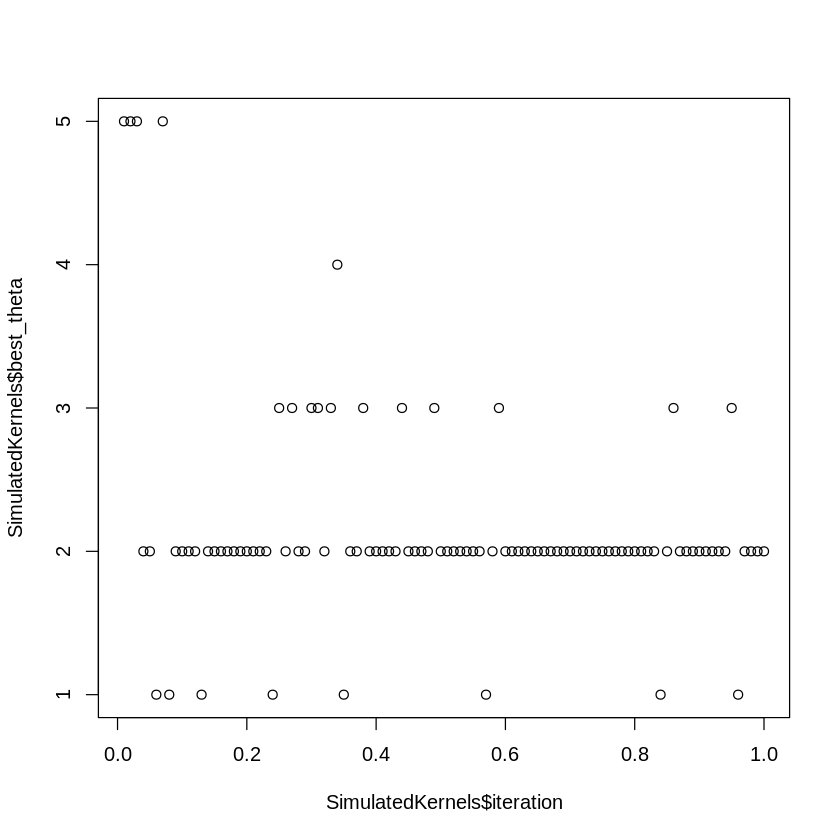

In [46]:
plot(SimulatedKernels$iteration, SimulatedKernels$best_theta)

In [5]:
write.csv(SimulatedKernels, file="~/parentage/kernel_fitting/1340_loci/final_results/SimulatedPropSamp2.csv", row.names=F, quote=FALSE)
SimulatedKernels <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/SimulatedPropSamp2.csv", header=T) %>%
    rename(prop_samp="iteration")

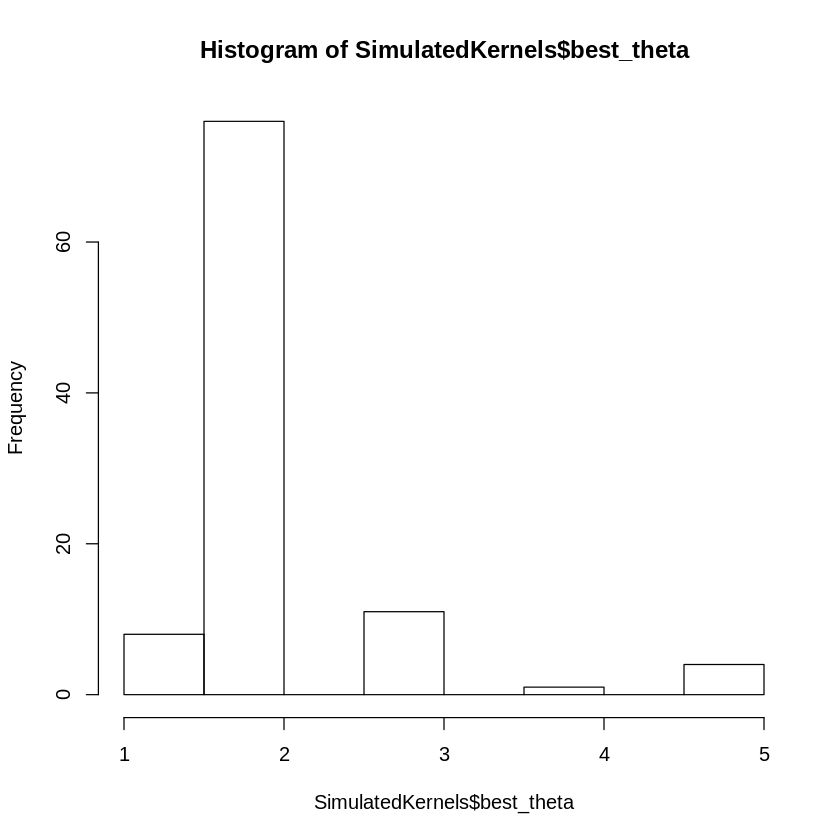

In [48]:
hist(SimulatedKernels$best_theta)

In [10]:
prop_samp_k <- ggplot(SimulatedKernels, aes(prop_samp, best_k)) + 
    geom_point() + 
    geom_smooth() +
    xlab("Sampling effort") + 
    ylab("MLE k")+ 
    theme(panel.grid.minor = element_blank(), panel.background = element_blank())+
    theme_classic()
#ggplot2::ggsave(filename="KPropSamp.pdf", plot=prop_samp_k, path="~/parentage/kernel_fitting/1340_loci/final_results/simulations/")


prop_samp_theta <- ggplot(SimulatedKernels, aes(prop_samp, best_theta)) + 
    geom_point() + 
    geom_smooth()+
    xlab("Sampling effort") + 
    ylab("MLE theta") + 
    theme_classic()
#ggplot2::ggsave(filename="ThetaPropSamp.pdf", plot=prop_samp_theta, path="~/parentage/kernel_fitting/1340_loci/final_results/simulations/")


Saving 6.67 x 6.67 in image
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Saving 6.67 x 6.67 in image
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


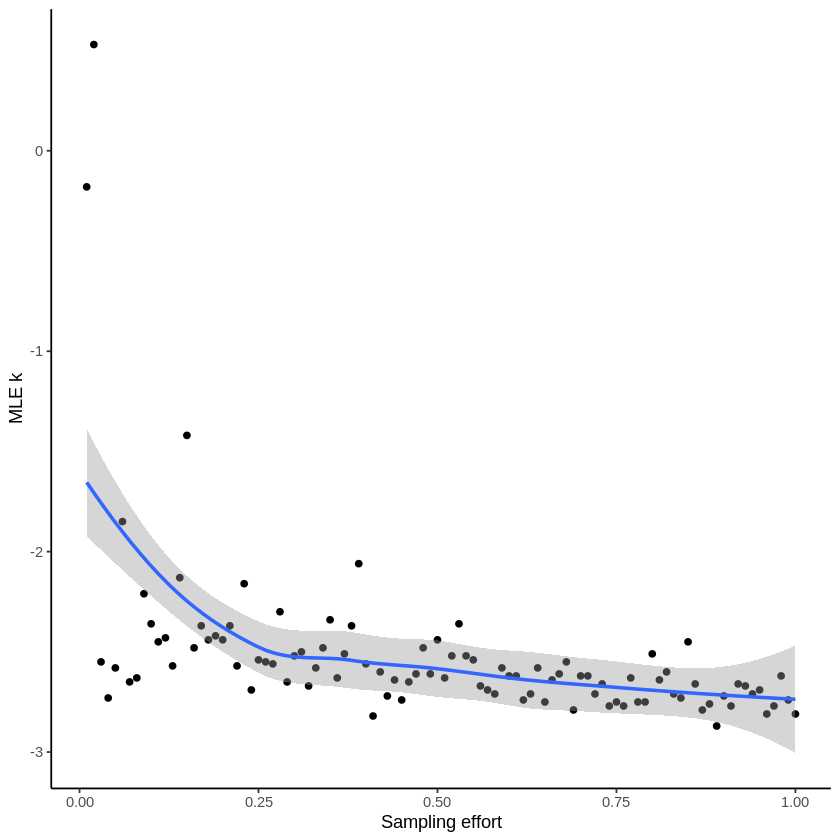

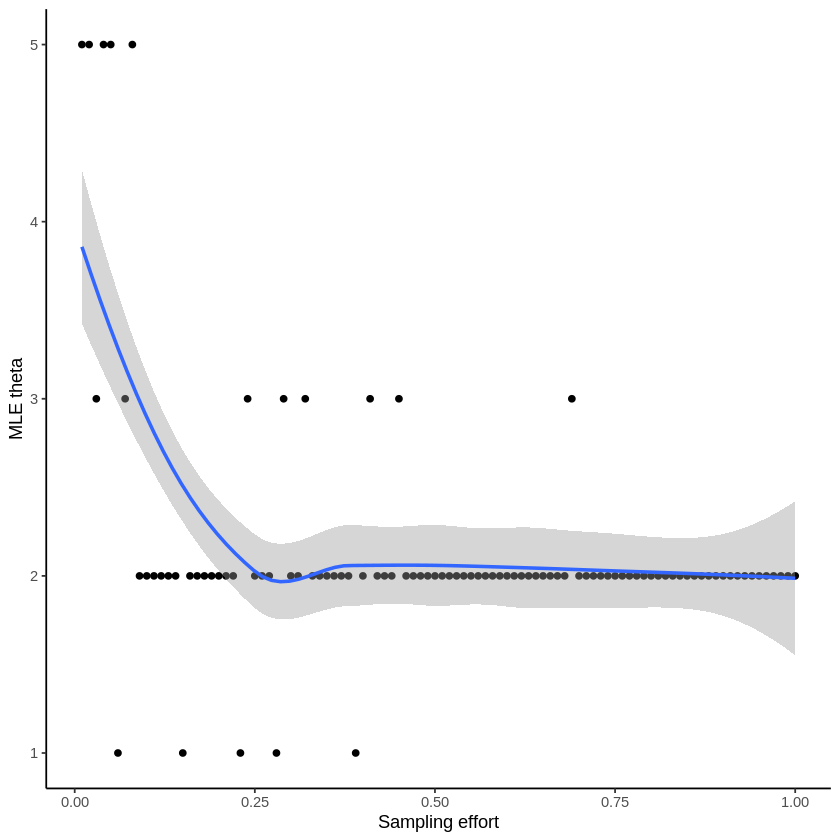

In [9]:
prop_samp_k
prop_samp_theta

In [10]:
k_mod <- lm(best_k ~ prop_samp, data=SimulatedKernels)
cor.test(SimulatedKernels$best_k, SimulatedKernels$prop_samp)
summary(k_mod)
theta_mod <- lm(best_theta ~ prop_samp, data=SimulatedKernels)
cor.test(SimulatedKernels$best_theta, SimulatedKernels$prop_samp)
summary(theta_mod)


	Pearson's product-moment correlation

data:  SimulatedKernels$best_k and SimulatedKernels$prop_samp
t = -4.7932, df = 98, p-value = 5.848e-06
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5823619 -0.2617823
sample estimates:
       cor 
-0.4357925 



Call:
lm(formula = best_k ~ prop_samp, data = SimulatedKernels)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.41563 -0.15369 -0.03401  0.05500  2.90117 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.19076    0.08253 -26.545  < 2e-16 ***
prop_samp   -0.68007    0.14188  -4.793 5.85e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4096 on 98 degrees of freedom
Multiple R-squared:  0.1899,	Adjusted R-squared:  0.1816 
F-statistic: 22.97 on 1 and 98 DF,  p-value: 5.848e-06



	Pearson's product-moment correlation

data:  SimulatedKernels$best_theta and SimulatedKernels$prop_samp
t = -3.9194, df = 98, p-value = 0.0001645
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5264723 -0.1850858
sample estimates:
       cor 
-0.3681211 



Call:
lm(formula = best_theta ~ prop_samp, data = SimulatedKernels)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4277 -0.4013 -0.1539  0.1127  2.4089 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.7352     0.1426  19.184  < 2e-16 ***
prop_samp    -0.9607     0.2451  -3.919 0.000164 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7075 on 98 degrees of freedom
Multiple R-squared:  0.1355,	Adjusted R-squared:  0.1267 
F-statistic: 15.36 on 1 and 98 DF,  p-value: 0.0001645


In [ ]:
#previous iteration looking at CI width below

In [2]:
#write.csv(SimulatedKernels, file="~/parentage/kernel_fitting/1340_loci/final_results/SimulatedPropSamp.csv", row.names=T, quote=FALSE)
SimulatedCI <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/SimulatedPropSamp.csv", header=T)


In [11]:
SimulatedCI

X,best_k,upper_k,lower_k,best_theta,upper_theta,lower_theta,iteration,kCI,thetaCI,prop_samp
1,9.8,9.8,-9.9,0.6,0.8,0.3,0.01,19.7,0.5,0.01
2,-2.1,-3.4,-10.0,0.6,0.7,0.1,0.02,6.6,0.6,0.02
3,6.2,8.1,-1.1,0.6,0.7,0.5,0.03,9.2,0.2,0.03
4,2.2,8.5,-9.7,0.6,0.7,0.2,0.04,18.2,0.5,0.04
5,6.9,7.5,-2.0,0.6,0.7,0.6,0.05,9.5,0.1,0.05
6,4.3,8.2,-5.1,0.6,0.7,0.5,0.06,13.3,0.2,0.06
7,8.2,8.5,5.0,0.6,0.6,0.5,0.07,3.5,0.1,0.07
8,7.1,9.4,-6.1,0.6,0.6,0.5,0.08,15.5,0.1,0.08
9,2.2,9.2,0.8,0.6,0.7,0.6,0.09,8.4,0.1,0.09
10,3.3,4.1,2.3,0.6,0.6,0.6,0.10,1.8,0.0,0.10


In [8]:
SimulatedCI <- SimulatedCI %>% 
    mutate(kCI=abs(upper_k-lower_k)) %>%
    mutate(thetaCI=abs(upper_theta-lower_theta)) %>%
    mutate(prop_samp=as.numeric(iteration))


In [16]:
k_mod <- lm(kCI ~ prop_samp, data=SimulatedCI)
cor.test(SimulatedCI$kCI, SimulatedCI$prop_samp)
#summary(k_mod)
theta_mod <- lm(thetaCI ~ prop_samp, data=SimulatedCI)
cor.test(SimulatedCI$thetaCI, SimulatedCI$prop_samp)
#summary(theta_mod)


	Pearson's product-moment correlation

data:  SimulatedCI$kCI and SimulatedCI$prop_samp
t = -0.64283, df = 98, p-value = 0.5218
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2579345  0.1333156
sample estimates:
        cor 
-0.06479932 



	Pearson's product-moment correlation

data:  SimulatedCI$thetaCI and SimulatedCI$prop_samp
t = -4.7968, df = 98, p-value = 5.764e-06
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5825790 -0.2620883
sample estimates:
       cor 
-0.4360586 


In [9]:
kCI <- ggplot(SimulatedCI, aes(prop_samp, best_k)) + 
    geom_point() + 
    geom_smooth(method = "lm") +
    xlab("Sampling effort") + 
    ylab("CI width (k)")+ 
    theme(panel.grid.minor = element_blank(), panel.background = element_blank())+
    theme_classic()
#ggplot2::ggsave(filename="KCIPropSamp.pdf", plot=kCI, path="~/parentage/kernel_fitting/1340_loci/final_results/simulations/")


thetaCI <- ggplot(SimulatedCI, aes(prop_samp, best_theta)) + 
    geom_point() + 
    geom_smooth(method = "lm")+
    xlab("Sampling effort") + 
    ylab("CI width (theta)") + 
    theme_classic()
#ggplot2::ggsave(filename="ThetaCIPropSamp.pdf", plot=thetaCI, path="~/parentage/kernel_fitting/1340_loci/final_results/simulations/")


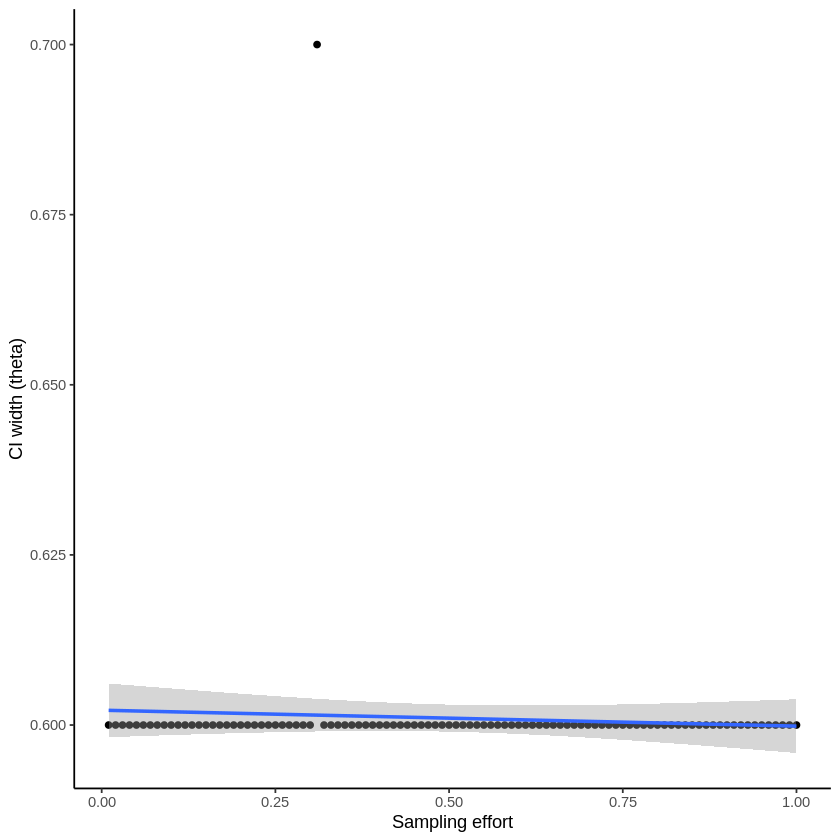

In [10]:
thetaCI

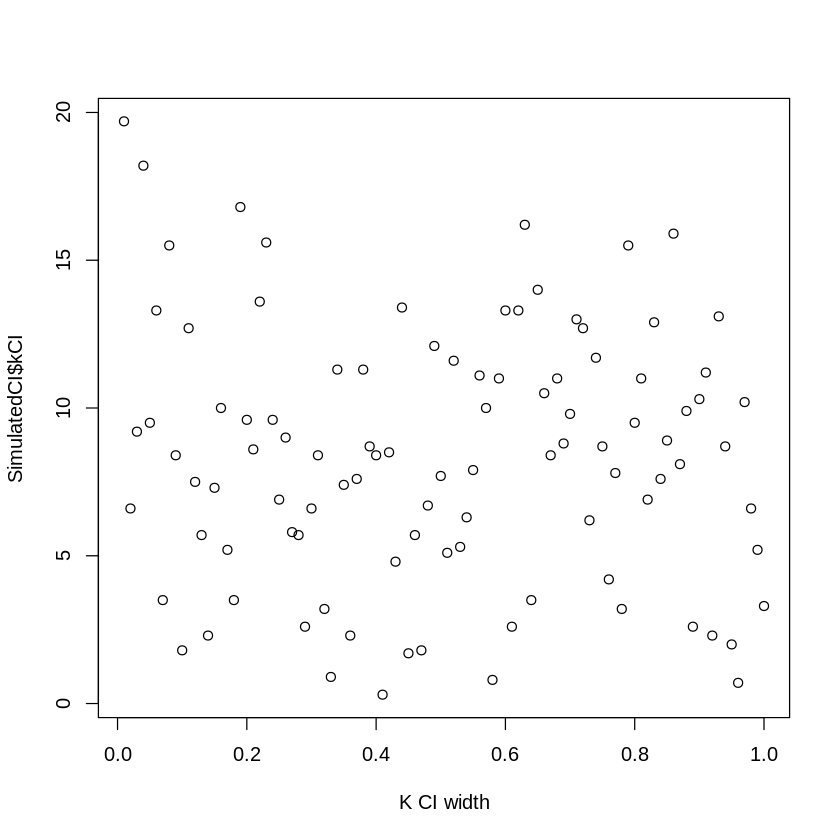

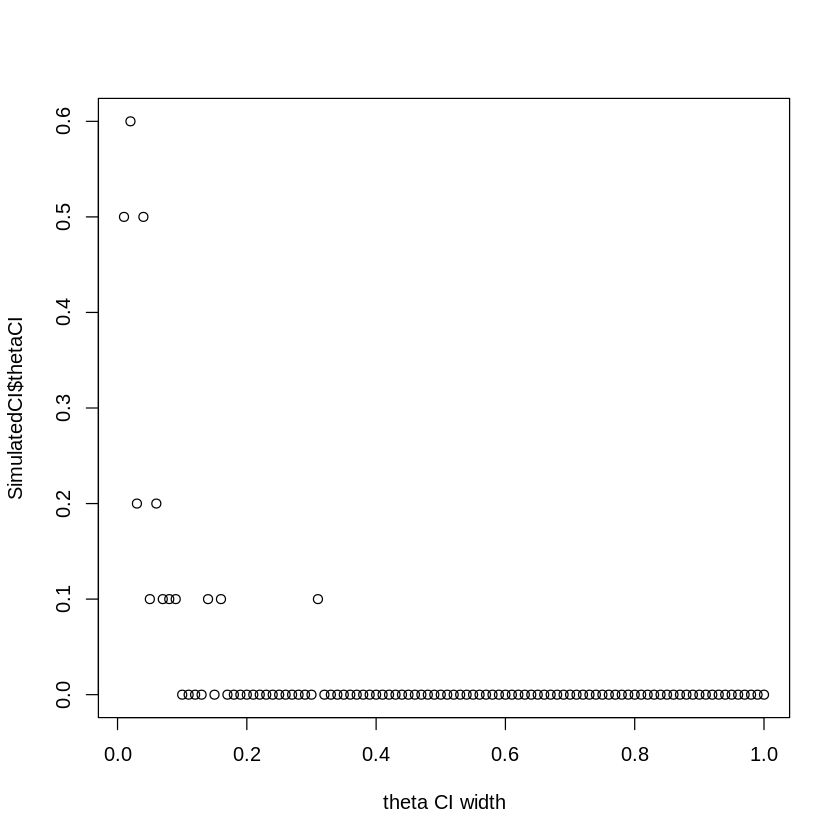

In [39]:
#pdf("~/parentage/kernel_fitting/1340_loci/final_results/simulations/MDDCV.pdf")
plot(SimulatedCI$kCI~ SimulatedCI$prop_samp, main=NA, xlab= "K CI width")
#dev.off()

#pdf("~/parentage/kernel_fitting/1340_loci/final_results/simulations/ThetaCV.pdf")
plot(SimulatedCI$thetaCI~ SimulatedCI$prop_samp, main=NA, xlab= "theta CI width")
#dev.off()


In [110]:
nll_df_beta$k_eval <- row.names(nll_df_beta)
nll_df <- nll_df_beta %>%
    gather(1:50, key="theta_eval", value="log_like")


In [61]:
#add in the unassigned juveniles
N_gen_offs_all <- SampledFish %>% 
    filter(input=="offspring") %>%
    group_by(site) %>%
    summarise(n_offs_gen=n())


N_gen_offs2 <- N_gen_offs_all %>%
    group_by(site) %>% #add group by year if doing annual
    summarise(sampled_fish=sum(n_offs_gen)) 


offs_matched_site <- allsites_parentage %>%
    group_by(offs_site) %>%
    summarise(n_offs=sum(n_matches, na.rm=T))


unassigned_beta <- left_join(sites, offs_matched_site, by=c(site="offs_site")) %>%
    select(site, n_offs) %>%
    group_by(site) %>%
    summarise(n_offs=sum(n_offs))

unassigned_beta[is.na(unassigned_beta)] <- 0

net_unassigned <- left_join(unassigned_beta, N_gen_offs2, by="site") %>%
    mutate(n_unassigned=sampled_fish-n_offs)


#                             
#
#net_unassigned <- left_join(unassigned_beta, N_gen_offs_all, by="site") %>%
#    mutate(n_unassigned=sampled_fish-n_matches)
#
##transpose to create a row, bind to the matrix
#
#row2add <- net_unassigned %>%
#    arrange(site) %>%
#    select(n_unassigned, site) %>%
#    group_by(site) %>%
#    filter(row_number()==1) %>%
#    ungroup() %>%
#    select(n_unassigned)
#row2addT <- as.data.frame(t(row2add))
#colnames(row2addT) <- colnames(parmat)
#
#parmat <- ungroup(parmat)
#parmat_full <- bind_rows(parmat, row2addT)
#parmat_full[is.na(parmat_full)] <- 0
#

In [63]:
dim(net_unassigned)

[1] 18  4

In [45]:
#add in the unassigned juveniles
N_gen_offs_all <- SampledFish %>% 
    filter(input=="offspring") %>%
    group_by(site) %>%
    summarise(n_offs_gen=n())


N_gen_offs2 <- N_gen_offs_all %>%
    group_by(site) %>% #add group by year if doing annual
    summarise(sampled_fish=sum(n_offs_gen)) 


#make dataframe with column for unassigned juveniles in each column (offspring site)
offs_matched_site <- allsites_parentage %>%
    group_by(offs_site) %>%
    summarise(n_offs=sum(n_matches, na.rm=T))

unassigned_beta <- semi_join(offs_matched_site, sites, by=c(offs_site="site")) %>%
    ungroup() %>%
    select(offs_site, n_offs)

#unassigned_beta[is.na(unassigned_beta)] <- 0


net_unassigned <- left_join(unassigned_beta, N_gen_offs2, by=c(offs_site="site")) %>%
    mutate(n_unassigned=sampled_fish-n_offs)
#transpose to create a row, bind to the matrix

row2add <- net_unassigned %>%
    arrange(offs_site) %>%
    select(n_unassigned, offs_site) %>%
    group_by(offs_site) %>%
    filter(row_number()==1) %>%
    ungroup() %>%
    select(n_unassigned)
row2addT <- as.data.frame(t(row2add))
colnames(row2addT) <- colnames(parmat)

parmat <- ungroup(parmat)
parmat_full <- bind_rows(parmat, row2addT)
parmat_full[is.na(parmat_full)] <- 0


site,total_prop_hab_sampled_anems_tidied
Cabatoan,0.5109890
Caridad Cemetery,0.3928571
Caridad Proper,1.0000000
Elementary School,0.7142857
Gabas,0.2222222
Haina,0.2527473
Hicgop South,0.4761905
N.Magbangon,0.2693878
S.Magbangon,0.3781513
Palanas,0.6485923


In [33]:
sites_all_beta <- sampled_sites %>%
    rename(par_site = "site") 
#undo here if there's a mistake 06/04/2019
sites_all_beta$offs_site <- sites_all_beta$par_site


allsites_parentage_NEM <- full_join(sites_all, total_all_years_NEM, by=c("par_site", "offs_site")) %>%
    group_by(offs_site, par_site) %>%
    filter(row_number()==1) %>%
    arrange(offs_site, par_site) %>%#be very careful to keep everything in alphabetical order, consitent with the "pop" indexing used in MigEst.
    ungroup()

[1] 18  2

offs_site,par_site,n_matches
S.Magbangon,Palanas,1


In [ ]:
##add in the unassigned juveniles
#N_gen_offs_all <- SampledFish %>% 
#    filter(input=="offspring") %>%
#    group_by(site) %>%
#    summarise(n_offs_gen=n())
#
#
#N_gen_offs2 <- N_gen_offs_all %>%
#    group_by(site) %>% #add group by year if doing annual
#    summarise(sampled_fish=sum(n_offs_gen)) 
#
#
##make dataframe with column for unassigned juveniles in each column (offspring site)
#offs_matched_site <- allsites_parentage %>%
#    group_by(offs_site) %>%
#    summarise(n_offs=sum(n_matches, na.rm=T))
#
#unassigned_beta <- semi_join(offs_matched_site, sites, by=c(offs_site="site")) %>%
#    ungroup() %>%
#    select(offs_site, n_offs)
#
##unassigned_beta[is.na(unassigned_beta)] <- 0
#
#
#net_unassigned <- left_join(unassigned_beta, N_gen_offs2, by=c(offs_site="site")) %>%
#    mutate(n_unassigned=sampled_fish-n_offs)
##transpose to create a row, bind to the matrix
#
#row2add <- net_unassigned %>%
#    arrange(offs_site) %>%
#    select(n_unassigned, offs_site) %>%
#    group_by(offs_site) %>%
#    filter(row_number()==1) %>%
#    ungroup() %>%
#    select(n_unassigned)
#row2addT <- as.data.frame(t(row2add))
#colnames(row2addT) <- colnames(parmat)
#
#parmat <- ungroup(parmat)
#parmat_full <- bind_rows(parmat, row2addT)
#parmat_full[is.na(parmat_full)] <- 0
#

In [32]:
Assignments <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/parentage_matrix_allyears.csv", header=FALSE))


In [42]:
dim(Assignments)

[1] 19 18

In [5]:
sites_all_beta

par_site,offs_site
Cabatoan,Cabatoan
Caridad Cemetery,Caridad Cemetery
Caridad Proper,Caridad Proper
Elementary School,Elementary School
Gabas,Gabas
Haina,Haina
Hicgop South,Hicgop South
N.Magbangon,N.Magbangon
S.Magbangon,S.Magbangon
Palanas,Palanas


In [45]:
allsites_parentage

par_site,offs_site,n_matches
Cabatoan,Cabatoan,NA
Caridad Cemetery,Caridad Cemetery,NA
Caridad Proper,Caridad Proper,NA
Elementary School,Elementary School,NA
Gabas,Gabas,NA
Haina,Haina,NA
Hicgop South,Hicgop South,NA
N.Magbangon,N.Magbangon,NA
Palanas,Palanas,NA
Poroc Rose,Poroc Rose,NA
